In [3]:
# !pip3 install torch
# !pip install scikit-learn

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [5]:
# get data
data = pd.read_csv("../usa/processed-usa-data.csv", delimiter=",", names=["Temperature_Bin", "Wind_Speed_Bin", "Amount_of_Accidents"], skiprows=1)
data = data.dropna()

In [54]:
# preprocess data
from sklearn.model_selection import train_test_split

accidents = data["Amount_of_Accidents"].values
accidents = accidents.sum() / len(accidents)

print("average accidents: ", accidents)

# Perform one-hot encoding on the categorical columns
temperature_encoded = pd.get_dummies(data["Temperature_Bin"], prefix="temperature")
wind_speed_encoded = pd.get_dummies(data["Wind_Speed_Bin"], prefix="wind_speed")

# Combine the encoded features with the amount of accidents
processed_data = pd.concat([temperature_encoded, wind_speed_encoded, data["Amount_of_Accidents"]], axis=1)

# Convert the processed data to PyTorch tensors
X = processed_data.iloc[:, :-1].values
y = processed_data.iloc[:, -1].values

X_train, x_val, y_train,  y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

average accidents:  20240.4


,Temperature_Bin,Wind_Speed_Bin,Amount_of_Accidents
0,Extremely Cold,No Wind,5175
1,Extremely Cold,Very Low,22582
2,Extremely Cold,Low,15178
3,Extremely Cold,Slightly Low,7546
4,Extremely Cold,Moderate Low,3503
...,...,...,...
95,Extremely Hot,Moderate High,99
96,Extremely Hot,Slightly High,19
97,Extremely Hot,High,3
98,Extremely Hot,Very High,0


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

lr = LinearRegression()
lr.fit(X_train, np.log(y_train + 1e-5))

rf = RandomForestRegressor()
rf.fit(X_train, np.log(y_train + 1e-5))

import joblib
# Save model with a higher protocol version
# joblib.dump(rf, "usa-model.pt", protocol=4)



['usa-model.pt']

In [ ]:
lr.score(x_val, np.log(y_val + 1e-5)),rf.score(x_val, np.log(y_val + 1e-5))

(0.45312342691723884, 0.9372714312721295)

Predicted amount of accidents: 28911.01
percent deviation from average accidents per month:  42.838%


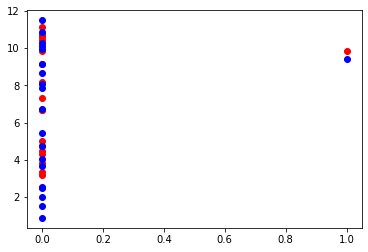

In [52]:
# Define the bins for temperature and wind speed
temperature_bins = [-float("inf"), -5, 0, 5, 10, 15, 20, 25, 30, 35, float("inf")]
wind_speed_bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, float("inf")]

# Assign labels to each bin
temperature_labels = [
    "Extremely Cold",
    "Very Cold",
    "Cold",
    "Slightly Cold",
    "Moderate Cold",
    "Moderate Hot",
    "Slightly Hot",
    "Hot",
    "Very Hot",
    "Extremely Hot",
]
wind_speed_labels = [
    "No Wind",
    "Very Low",
    "Low",
    "Slightly Low",
    "Moderate Low",
    "Moderate High",
    "Slightly High",
    "High",
    "Very High",
    "Extremely High",
]

current_temperature = 15
current_wind_speed = 10

# Encode the current temperature and wind speed values into one-hot encoding
temperature_index = next((i for i, bin in enumerate(temperature_bins) if current_temperature <= bin), len(temperature_bins) - 1)
wind_speed_index = next((i for i, bin in enumerate(wind_speed_bins) if current_wind_speed <= bin))

# hacky way to solve out of index error
if wind_speed_index == len(wind_speed_bins)-1: wind_speed_index -= 1

encoded_temperature = [0] * len(temperature_labels)
encoded_temperature[temperature_index] = 1

encoded_wind_speed = [0] * len(wind_speed_labels)
encoded_wind_speed[wind_speed_index] = 1


# Combine the encoded values into a single input tensor
input_tensor = torch.tensor([encoded_temperature + encoded_wind_speed], dtype=torch.float32)

# Make the prediction using the trained model for the amount of accidents for the span of the dataset(2016-2020, or 4 years)
predicted = rf.predict(input_tensor) # in log space
predicted = np.exp(predicted) - 1e-5

# scale down to 1 month
predicted = predicted / 48

print(f"Predicted amount of accidents: {predicted.item():.2f}")
deviation = (predicted.item() - 20240.4) / 20240.4 * 100
print("percent deviation from average accidents per month: ", str(round(deviation, 3)) + "%")
